In [1]:
import torch
from model import UNet

## 1. Initialize PyTorch model (Choroidalyzer)

In [2]:
model = UNet(in_channels=1, out_channels=3, depth=7, channels='8_doublemax-64', up_type='conv_then_interpolate', extra_out_conv=True)

# Download weights from github
DEFAULT_MODEL_URL = 'https://github.com/justinengelmann/Choroidalyzer/releases/download/v1.0/choroidalyzer_model_weights.pth'
state_dict = torch.hub.load_state_dict_from_url(DEFAULT_MODEL_URL, map_location='cpu')
model.load_state_dict(state_dict)

model.eval()
model.to('cpu')

UNet(
  (in_conv): ConvNormAct(
    (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (down_blocks): ModuleList(
    (0): DownBlock(8->16)
    (1): DownBlock(16->32)
    (2): DownBlock(32->64)
    (3-6): 4 x DownBlock(64->64)
  )
  (up_blocks): ModuleList(
    (0-3): 4 x UpBlock(conv_then_interpolate, 64->64)
    (4): UpBlock(conv_then_interpolate, 64->32)
    (5): UpBlock(conv_then_interpolate, 32->16)
    (6): UpBlock(conv_then_interpolate, 16->8)
  )
  (out_conv): Sequential(
    (0): ConvNormAct(
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): Conv2d(8, 3, kernel_size=(1, 1), stride=(1, 1))
  )
)

## 2. Convert to ONNX

See more at https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html

### 2A. Initialize & Preprocess Example Inputs
To export the model to ONNX format, we have to provide an example input for PyTorch to trace the NN graph. So, we load an example choroidalyzer image here and preprocess it. Generally, the example input values doesn't really matter, and it's mostly the **example input shape** that is important when performing ONNX export.

In [3]:
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
from torchvision.io import decode_image, ImageReadMode

In [4]:
img = decode_image('./example_data/image1.png', mode=ImageReadMode.GRAY)
if img.ndim == 2: # add dummy channel dim if needed
    img = img.unsqueeze(0)
img.shape

torch.Size([1, 768, 768])

In [5]:
def get_default_img_transforms():
    return T.Compose([
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=(0.5,), std=(0.5,)),
    ])
example_inputs = tv_tensors.Image(img)
example_inputs = get_default_img_transforms()(example_inputs)
example_inputs = example_inputs.unsqueeze(0)
example_inputs.shape

torch.Size([1, 1, 768, 768])

In [6]:
# Run model inference to make sure everything works
model(example_inputs)

tensor([[[[-7.1774, -6.8285, -7.2596,  ..., -7.2578, -6.8562, -6.4384],
          [-7.5012, -8.2761, -8.4533,  ..., -7.6219, -7.3928, -6.4709],
          [-8.1005, -8.4176, -8.7058,  ..., -8.0664, -8.0312, -6.5820],
          ...,
          [-7.5847, -7.5296, -7.6107,  ..., -7.8909, -7.8586, -6.6194],
          [-7.4439, -7.1894, -7.2697,  ..., -7.8515, -7.5879, -6.6249],
          [-7.0515, -7.0758, -7.2920,  ..., -7.4256, -7.3977, -7.2482]],

         [[-8.3682, -7.9248, -8.1511,  ..., -8.6162, -8.0813, -7.8296],
          [-7.9580, -8.2148, -8.2572,  ..., -8.1292, -8.0913, -7.6599],
          [-8.7024, -8.3568, -8.4323,  ..., -8.5633, -8.4517, -7.5138],
          ...,
          [-8.6128, -8.2900, -8.0733,  ..., -8.5177, -8.3947, -7.8836],
          [-8.3639, -7.9682, -8.0582,  ..., -8.4796, -7.8353, -7.3938],
          [-8.1591, -8.0176, -8.1776,  ..., -8.2127, -7.9474, -8.5317]],

         [[-4.4415, -4.4523, -4.6156,  ..., -4.7791, -4.6205, -4.2094],
          [-4.6948, -5.6250, -

### 2B. Convert PyTorch Model to ONNX

In [7]:
import onnx, onnxscript

In [8]:
# Create ONNX representation of model
onnx_program = torch.onnx.export(model, example_inputs, dynamo=True)

/Users/raj/code/miniconda3/envs/imind_cnn_app/lib/python3.11/site-packages/onnxscript/converter.py:816: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/Users/raj/code/miniconda3/envs/imind_cnn_app/lib/python3.11/site-packages/onnxscript/converter.py:816: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


[torch.onnx] Obtain model graph for `UNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `UNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [9]:
# (Optional) in-place optimization of ONNX graph
onnx_program.optimize()

In [10]:
# Save ONNX file
ONNX_FILENAME = "choroidalyzer.onnx"
onnx_program.save(ONNX_FILENAME)

In [11]:
# Load ONNX file & check basic validity
onnx_model = onnx.load(ONNX_FILENAME)
onnx.checker.check_model(onnx_model)

## 3. Perform Inference w/ ONNX

In [12]:
import onnxruntime as ort
import numpy as np
from matplotlib import pyplot as plt

session = ort.InferenceSession(ONNX_FILENAME, providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
raw_preds = session.run(None, {input_name: example_inputs.numpy()})[0]

# Run sigmoid on raw ONNX output (could do this manually/without pytorch, if desired!)
sigmoided_preds = torch.from_numpy(raw_preds).squeeze(0).sigmoid().cpu().numpy()

In [13]:
# Calculate masks based on thresholds
DEFAULT_THRESHOLDS = (0.5, 0.5, 0.1)
thresholds = DEFAULT_THRESHOLDS
region_mask = sigmoided_preds[0] >= thresholds[0]
vessel_mask = sigmoided_preds[1] >= thresholds[1]

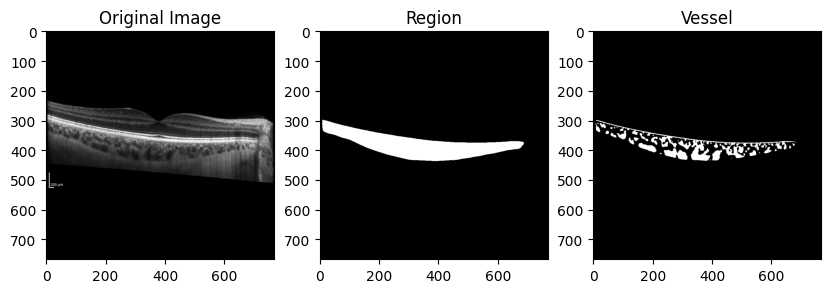

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].set_title('Original Image')
axes[0].imshow(img.permute(1, 2, 0), cmap='gray')

axes[1].set_title('Region')
axes[1].imshow(region_mask, cmap='gray')

axes[2].set_title('Vessel')
axes[2].imshow(vessel_mask, cmap='gray')

## All Done!
You can also try out https://netron.app to visualize the architecure of the exported ONNX model and verify that it is as expected.